# 데이터 전처리

In [1]:
import pandas as pd

df = pd.read_csv('../../data/preprocessed_train.csv')
df = df[['data', 'label']]

df.head()

,data,label
0,지금 너 스스로를 죽여달라고 애원하는 것인가 ? 아닙니다 . 죄송합니다 . 죽을 거...,0
1,길동경찰서입니다 . 시 분 마트에 폭발물을 설치할거다 . 네 ? 똑바로 들어 한번만...,0
2,너 되게 귀여운거 알지 ? 나보다 작은 남자는 첨봤어 . 그만해 . 니들 놀리는거 ...,3
3,어이 거기 예 ? ? 너 말이야 너 . 이리 오라고 무슨 일 . 너 옷 좋아보인다 ...,1
4,저기요 혹시 날이 너무 뜨겁잖아요 ? 저희 회사에서 이 선크림 파는데 한 번 손등에...,1


In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf


tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


def data_load(num_words=20000):
    
    X = df['data']
    Y = tf.keras.utils.to_categorical(df['label'], num_classes=4, dtype='float32')
    
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
    
    def tokenize(data):
        result = []
        for sentence in data:
            temp = tokenizer.morphs(sentence)
            temp = [word for word in temp if not word in stopwords] 
            result.append(temp)
        return result
   
    X_train = tokenize(x_train)
    X_test = tokenize(x_test)
    X_val = tokenize(x_val)
                                                         
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = { word:index for index, word in enumerate(vocab) }
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    X_val = list(map(wordlist_to_indexlist, X_val))
                                                                                                             
    return X_train, y_train, X_test, y_test, X_val, y_val, word_to_index

x_train, y_train, x_test, y_test, x_val, y_val, word_to_index = data_load()
index_to_word = { index: word for word, index in word_to_index.items() }

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=70)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=70)

x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val,
                                                      value=word_to_index["<PAD>"],
                                                      padding='pre',
                                                      maxlen=70)

vocab_size = len(word_to_index)
word_vector_dim = 128

# 모델 설계

In [3]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, GlobalMaxPooling1D
from tensorflow.keras.layers import Input, Conv1D, Dropout, Concatenate, Add
from keras.models import Model

In [4]:
def CNN(vocab_size, word_vector_dim):
    
    inputs = Input(shape=(None, ))
    embedding = Embedding(vocab_size, word_vector_dim)(inputs)
    
    branches = []
    for filter_size in [3, 3]:
        branch = Conv1D(64, filter_size, activation='relu')(embedding)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)
    
    out = Concatenate()(branches)
    out = Dense(32, activation='relu')(out)
    out = Dropout(0.5)(out)
    
    out = Dense(4, activation='softmax')(out)
    model = Model(inputs=inputs, outputs=out)
    
    return model

In [5]:
def BiLSTM(vocab_size, word_vector_dim):
    
    inputs = Input(shape=(None, ))
    embedding = Embedding(vocab_size, word_vector_dim)(inputs)
    
    out = Bidirectional(LSTM(64, dropout=0.1, return_sequences=True))(embedding)
    out = GlobalMaxPooling1D()(out)
    
    out = Dense(4, activation='softmax')(out)
    model = Model(inputs=inputs, outputs=out)
    
    return model

In [6]:
def BiLSTM_LSTM(vocab_size, word_vector_dim):
    
    inputs = Input(shape=(None, ))
    embedding = Embedding(vocab_size, word_vector_dim)(inputs)
    
    bi_lstm = Bidirectional(LSTM(64, dropout=0.1, return_sequences=True))(embedding)
    residual_connection = Add()([embedding, bi_lstm])
    
    out = LSTM(64, return_sequences=True)(residual_connection)
    out = GlobalMaxPooling1D()(out)
    out = Dense(32, activation='relu')(out)
    out = Dropout(0.5)(out)
    
    out = Dense(4, activation='softmax')(out)
    model = Model(inputs=inputs, outputs=out)
    
    return model

In [37]:
def CNN_BiLSTM_LSTM(vocab_size, word_vector_dim):
    
    inputs = Input(shape=(None, ))
    embedding = Embedding(vocab_size, word_vector_dim)(inputs)
    
    conv1 = Conv1D(64, 3, activation='relu')(embedding)
    conv_drop = Dropout(0.5)(embedding)
    
    bi_lstm = Bidirectional(LSTM(64, dropout=0.1, return_sequences=True))(conv_drop)
    residual_connection = Add()([embedding, bi_lstm])
    
    out = LSTM(64, return_sequences=True)(residual_connection)
    out = GlobalMaxPooling1D()(out)
    out = Dense(32, activation='relu')(out)
    out = Dropout(0.5)(out)
    
    out = Dense(4, activation='softmax')(out)
    model = Model(inputs=inputs, outputs=out)
    
    return model

# 모델 학습

In [35]:
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)


class ClassifierModel():
    def __init__(self, _type, vocab_size, word_vector_dim):
        super(ClassifierModel, self).__init__()
        
        self.title = self.set_title(_type)
        
        if _type == 'cnn':
            self.model = CNN(vocab_size, word_vector_dim)
        elif _type == 'bi_lstm':
            self.model = BiLSTM(vocab_size, word_vector_dim)
        elif _type == 'bi_lstm_lstm':
            self.model = BiLSTM_LSTM(vocab_size, word_vector_dim)
        else:
            self.model = CNN_BiLSTM_LSTM(vocab_size, word_vector_dim)
            
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
                
        self.history = None
        self.es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
            
    def set_title(self, _type):
        if _type == 'cnn':
            return 'CNN'
        elif _type == 'bi_lstm':
            return 'BiLSTM'
        elif _type == 'bi_lstm_lstm':
            return 'BiLSTM_LSTM'
        else:
            return 'CNN_BiLSTM_LSTM'
    
    
    def summary(self):
        return self.model.summary()
    
    
    def train(self, x, y, x_val, y_val):
        self.history = self.model.fit(
            x, y, epochs=20, batch_size=64,
            validation_data=(x_val, y_val), callbacks=self.es, verbose=1)
    
    def evaluate(self, x, y):
        return self.model.evaluate(x, y, verbose=2)
    
    
    def show_history(self):
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title(f'{self.title} accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title(f'{self.title} loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        
    
    def show_report(self, x, y):
        y_pred = self.model.predict(x).argmax(axis=1)
        y_true = y.argmax(axis=1)
        
        print(f'accuracy : {accuracy_score(y_true, y_pred)}')
        print(f'macro f1 : {f1_score(y_true, y_pred, average="macro")}')
        print(f'weighted f1 : {f1_score(y_true, y_pred, average="weighted")}')
        
        conf_matrix = confusion_matrix(y_true, y_pred)
        names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘"]
        conf_matrix = pd.DataFrame(conf_matrix, index=names, columns=names)
        sns.heatmap(conf_matrix, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.show()

# 1. CNN

In [17]:
cnn = ClassifierModel('cnn', vocab_size, word_vector_dim)
cnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    1280000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 64)     24640       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     24640       embedding[0][0]                  
______________________________________________________________________________________________

In [18]:
cnn.train(x_train, y_train, x_val, y_val)

Epoch 1/20
40/40 [==============================] - 4s 16ms/step - loss: 1.3576 - accuracy: 0.3180 - val_loss: 1.2964 - val_accuracy: 0.5013
Epoch 2/20
40/40 [==============================] - 0s 5ms/step - loss: 1.1581 - accuracy: 0.5672 - val_loss: 0.9984 - val_accuracy: 0.7025
Epoch 3/20
40/40 [==============================] - 0s 6ms/step - loss: 0.8145 - accuracy: 0.7160 - val_loss: 0.6990 - val_accuracy: 0.7430
Epoch 4/20
40/40 [==============================] - 0s 5ms/step - loss: 0.6068 - accuracy: 0.7907 - val_loss: 0.5909 - val_accuracy: 0.7924
Epoch 5/20
40/40 [==============================] - 0s 6ms/step - loss: 0.4428 - accuracy: 0.8647 - val_loss: 0.5361 - val_accuracy: 0.8063
Epoch 6/20
40/40 [==============================] - 0s 5ms/step - loss: 0.3139 - accuracy: 0.9110 - val_loss: 0.5072 - val_accuracy: 0.8139
Epoch 7/20
40/40 [==============================] - 0s 6ms/step - loss: 0.2105 - accuracy: 0.9537 - val_loss: 0.4964 - val_accuracy: 0.8228
Epoch 8/20
40/40 [=

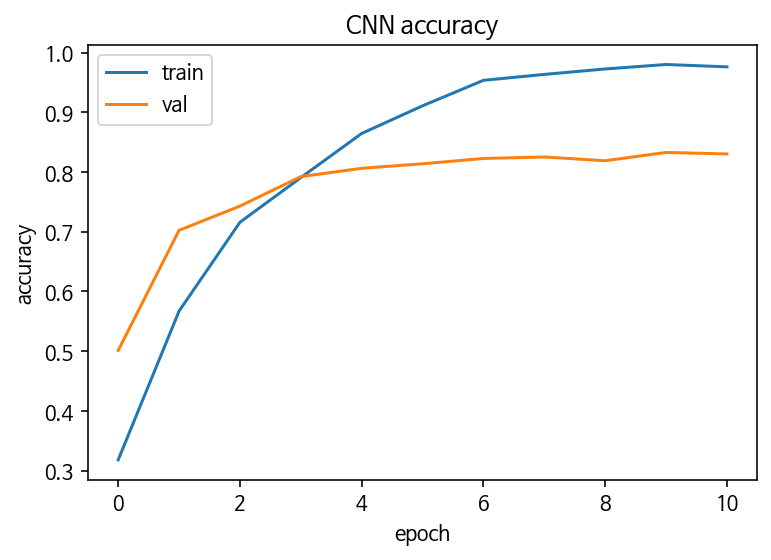

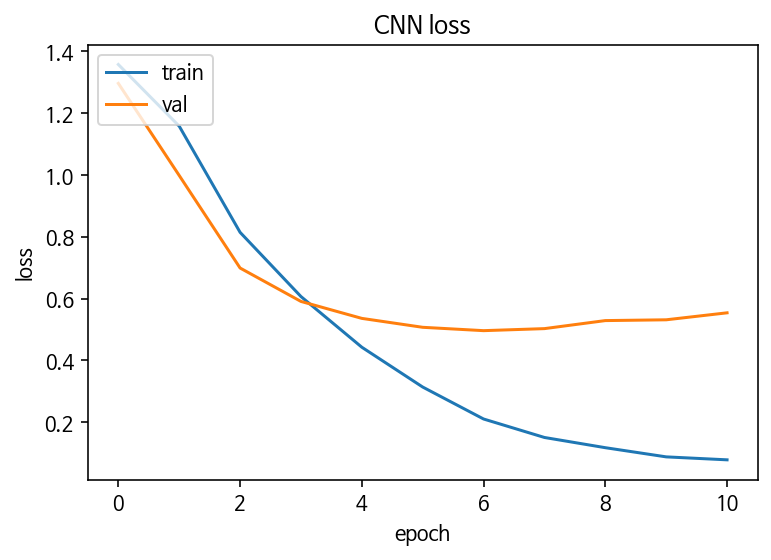

In [19]:
cnn.show_history()

In [20]:
cnn.evaluate(x_test, y_test)

20/20 - 0s - loss: 0.4469 - accuracy: 0.8560


[0.4468875825405121, 0.8560126423835754]

accuracy : 0.8560126582278481
macro f1 : 0.8579390466462182
weighted f1 : 0.8556722359257204


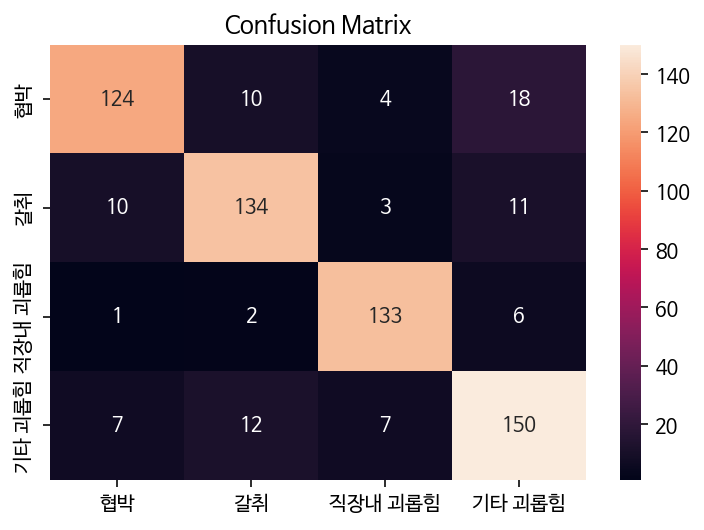

In [21]:
cnn.show_report(x_test, y_test)

# BiLSTM

In [22]:
bilstm = ClassifierModel('bi_lstm', vocab_size, word_vector_dim)
bilstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         98816     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 1,379,332
Trainable params: 1,379,332
Non-trainable params: 0
_________________________________________________________________


In [23]:
bilstm.train(x_train, y_train, x_val, y_val)

Epoch 1/20
40/40 [==============================] - 4s 28ms/step - loss: 1.3277 - accuracy: 0.4090 - val_loss: 1.1691 - val_accuracy: 0.3911
Epoch 2/20
40/40 [==============================] - 0s 10ms/step - loss: 0.8450 - accuracy: 0.6828 - val_loss: 0.7083 - val_accuracy: 0.7430
Epoch 3/20
40/40 [==============================] - 0s 10ms/step - loss: 0.4024 - accuracy: 0.8643 - val_loss: 0.6562 - val_accuracy: 0.7519
Epoch 4/20
40/40 [==============================] - 0s 10ms/step - loss: 0.1788 - accuracy: 0.9462 - val_loss: 0.7193 - val_accuracy: 0.7595
Epoch 5/20
40/40 [==============================] - 0s 10ms/step - loss: 0.1066 - accuracy: 0.9707 - val_loss: 0.7164 - val_accuracy: 0.7810
Epoch 6/20
40/40 [==============================] - 0s 10ms/step - loss: 0.0587 - accuracy: 0.9854 - val_loss: 0.8368 - val_accuracy: 0.7658
Epoch 7/20
40/40 [==============================] - 0s 10ms/step - loss: 0.0498 - accuracy: 0.9862 - val_loss: 0.8819 - val_accuracy: 0.7570
Epoch 00007: 

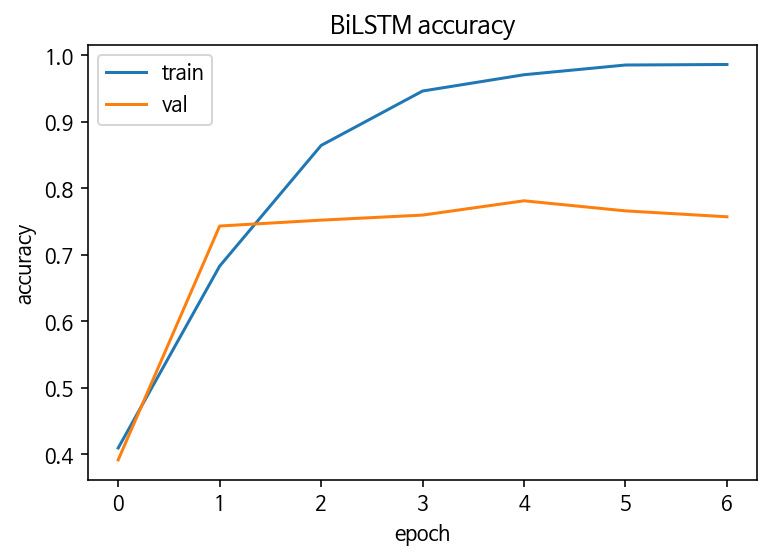

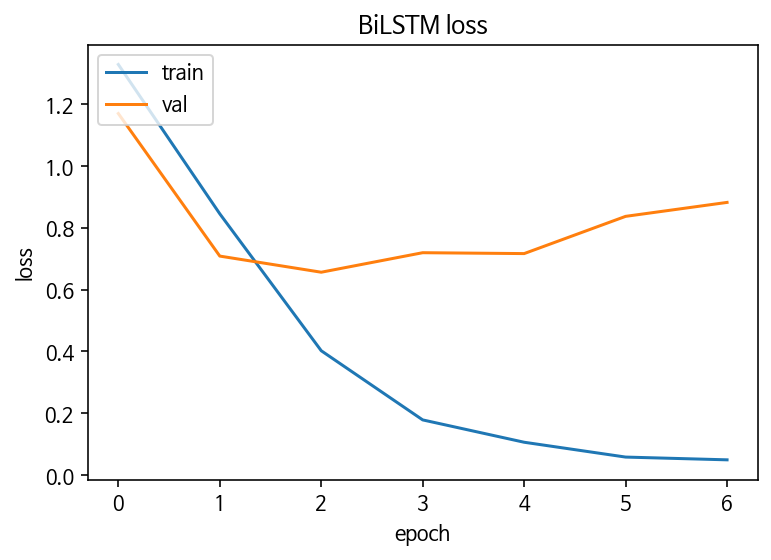

In [24]:
bilstm.show_history()

In [25]:
bilstm.evaluate(x_test, y_test)

20/20 - 0s - loss: 0.6785 - accuracy: 0.8133


[0.6784698367118835, 0.8132911324501038]

accuracy : 0.8132911392405063
macro f1 : 0.8157740095111833
weighted f1 : 0.8138469960383041


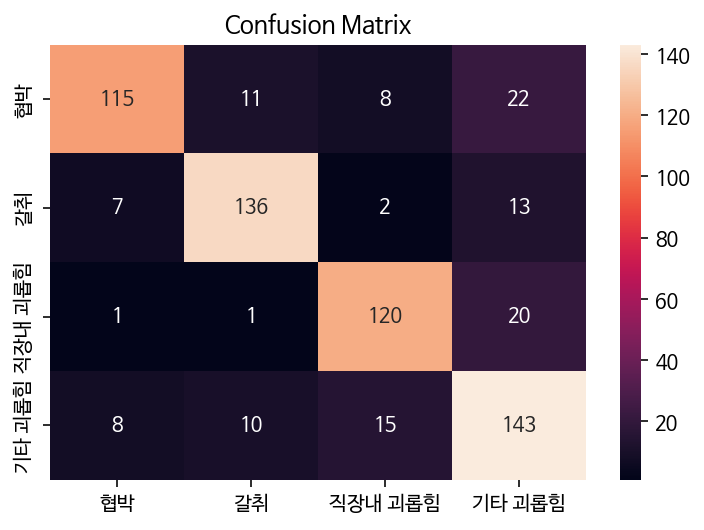

In [26]:
bilstm.show_report(x_test, y_test)

# 2. BiLSTM + LSTM

In [27]:
bilstm_lstm = ClassifierModel('bi_lstm_lstm', vocab_size, word_vector_dim)
bilstm_lstm.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 128)    1280000     input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, None, 128)    98816       embedding_2[0][0]                
__________________________________________________________________________________________________
add (Add)                       (None, None, 128)    0           embedding_2[0][0]                
                                                                 bidirectional_1[0][0]      

In [28]:
bilstm_lstm.train(x_train, y_train, x_val, y_val)

Epoch 1/20
40/40 [==============================] - 5s 38ms/step - loss: 1.3571 - accuracy: 0.3331 - val_loss: 1.1874 - val_accuracy: 0.4949
Epoch 2/20
40/40 [==============================] - 1s 13ms/step - loss: 0.9929 - accuracy: 0.6060 - val_loss: 0.7683 - val_accuracy: 0.7253
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 0.5771 - accuracy: 0.8192 - val_loss: 0.7700 - val_accuracy: 0.7177
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 0.3507 - accuracy: 0.9007 - val_loss: 0.8465 - val_accuracy: 0.7646
Epoch 5/20
40/40 [==============================] - 1s 13ms/step - loss: 0.2216 - accuracy: 0.9407 - val_loss: 0.7764 - val_accuracy: 0.7747
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 0.1308 - accuracy: 0.9628 - val_loss: 0.9128 - val_accuracy: 0.7785
Epoch 00006: early stopping


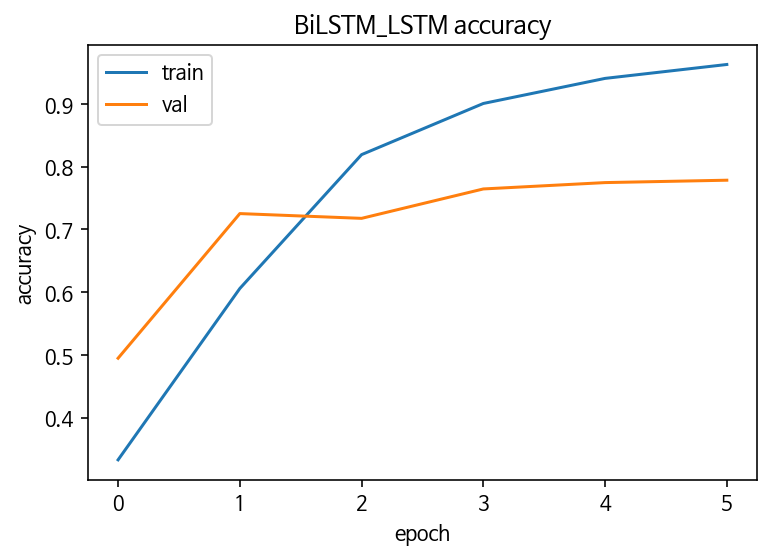

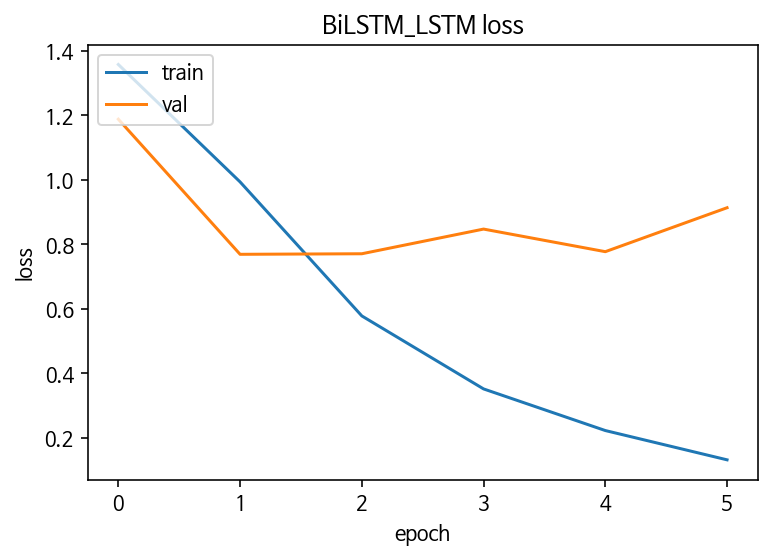

In [29]:
bilstm_lstm.show_history()

In [30]:
bilstm_lstm.evaluate(x_test, y_test)

20/20 - 0s - loss: 0.7841 - accuracy: 0.8054


[0.7840700745582581, 0.8053797483444214]

accuracy : 0.805379746835443
macro f1 : 0.808679254630615
weighted f1 : 0.80602473438156


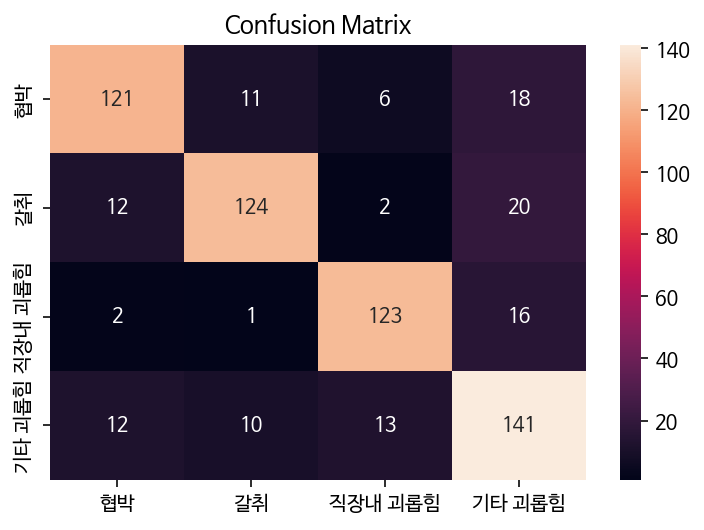

In [31]:
bilstm_lstm.show_report(x_test, y_test)

# CNN + BiLSTM + LSTM

In [38]:
cnn_bilstm_lstm = ClassifierModel('cnn_bilstm_lstm', vocab_size, word_vector_dim)
cnn_bilstm_lstm.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 128)    1280000     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, None, 128)    0           embedding_5[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, None, 128)    98816       dropout_5[0][0]                  
____________________________________________________________________________________________

In [39]:
cnn_bilstm_lstm.train(x_train, y_train, x_val, y_val)

Epoch 1/20
40/40 [==============================] - 5s 38ms/step - loss: 1.3657 - accuracy: 0.3339 - val_loss: 1.2522 - val_accuracy: 0.5253
Epoch 2/20
40/40 [==============================] - 1s 13ms/step - loss: 1.0341 - accuracy: 0.5696 - val_loss: 0.7605 - val_accuracy: 0.6962
Epoch 3/20
40/40 [==============================] - 1s 13ms/step - loss: 0.6122 - accuracy: 0.7868 - val_loss: 0.6097 - val_accuracy: 0.7899
Epoch 4/20
40/40 [==============================] - 1s 13ms/step - loss: 0.3579 - accuracy: 0.9031 - val_loss: 0.5217 - val_accuracy: 0.8177
Epoch 5/20
40/40 [==============================] - 0s 13ms/step - loss: 0.2445 - accuracy: 0.9308 - val_loss: 0.5476 - val_accuracy: 0.8089
Epoch 6/20
40/40 [==============================] - 1s 13ms/step - loss: 0.1446 - accuracy: 0.9688 - val_loss: 0.6919 - val_accuracy: 0.8038
Epoch 7/20
40/40 [==============================] - 1s 14ms/step - loss: 0.1075 - accuracy: 0.9743 - val_loss: 0.8078 - val_accuracy: 0.8127
Epoch 8/20
40

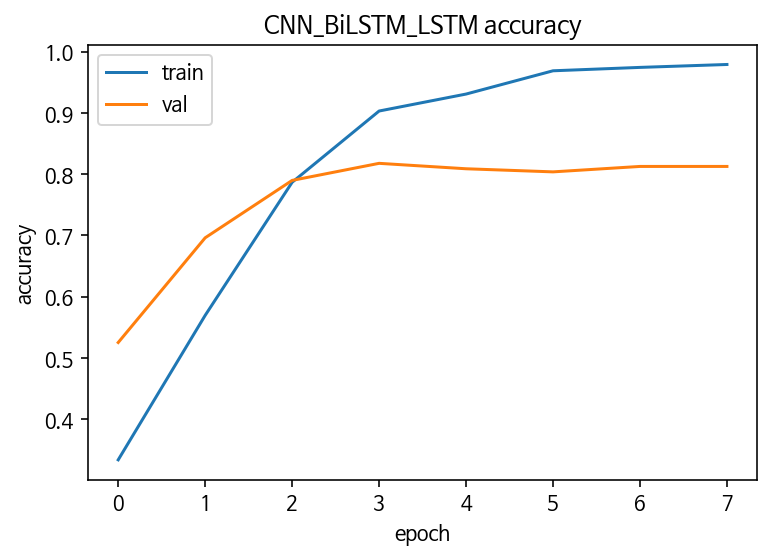

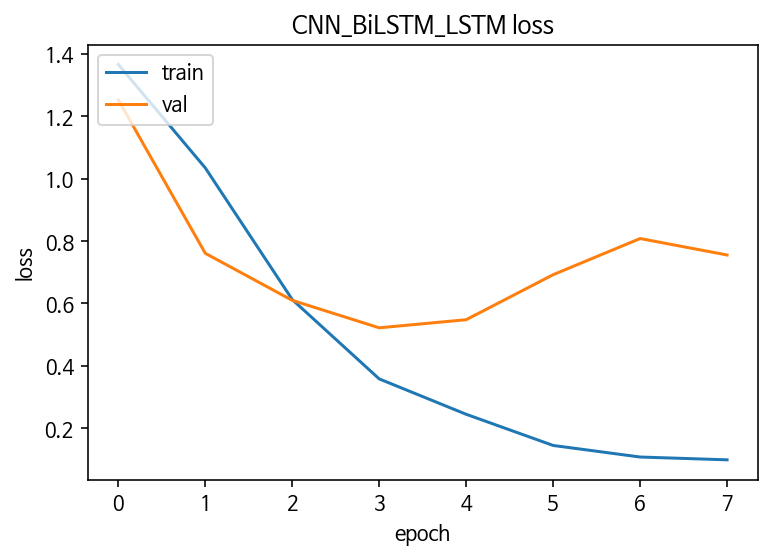

In [40]:
cnn_bilstm_lstm.show_history()

In [41]:
cnn_bilstm_lstm.evaluate(x_test, y_test)

20/20 - 0s - loss: 0.7143 - accuracy: 0.8259


[0.7142762541770935, 0.8259493708610535]

accuracy : 0.8259493670886076
macro f1 : 0.827572107814945
weighted f1 : 0.8264087942299372


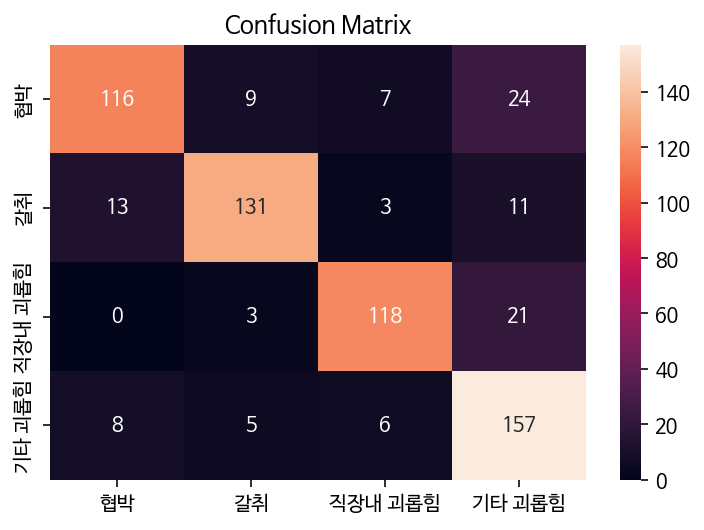

In [42]:
cnn_bilstm_lstm.show_report(x_test, y_test)

|모델|Loss|Accuracy|weighted f1|macro f1|
|:---:|---|---|---|:---:|
|CNN|0.4469|0.8560|0.8557|0.8579|
|BiLSTM|0.6785|0.8133|0.8138|0.8158|
|BiLSTM + LSTM|0.7841|0.8291|
|CNN + BiLSTM + LSTM|0.6968|0.8038|

accuracy : 0.805379746835443
macro f1 : 0.808679254630615
weighted f1 : 0.80602473438156